In [276]:
#Task 1: Retrieving and Preparing the Data (5%)
#Being a careful data scientist, you know that it is vital to set the goal of the project, then
#thoroughly pre-process any available data (each attribute) before starting to analyse and model
#it. In your report in Task 4, You need to clearly state the goal of your project, and the design/steps of
#pre-processing your data. Please ensure you understand the data you selected.

In [277]:
#import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import datetime as dt
from sklearn import datasets, linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
import seaborn as sns
from sklearn.cluster import Birch
from sklearn.pipeline import Pipeline
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, validation_curve
from sklearn.metrics import confusion_matrix, classification_report, recall_score, precision_score, f1_score,r2_score
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import DBSCAN

In [278]:
#import retail file
data = pd.read_excel('online_retail_II.xlsx', sheet_name="Year 2009-2010")

In [279]:
#display data
data

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.0,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.0,United Kingdom


In [280]:
data.describe()

,Quantity,Price,Customer ID
count,525461.000000,525461.000000,417534.000000
mean,10.337667,4.688834,15360.645478
std,107.424110,146.126914,1680.811316
min,-9600.000000,-53594.360000,12346.000000
25%,1.000000,1.250000,13983.000000
50%,3.000000,2.100000,15311.000000
75%,10.000000,4.210000,16799.000000
max,19152.000000,25111.090000,18287.000000


In [281]:
data.isna().sum()

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

In [282]:
data = data.dropna()
data

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.0,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.0,United Kingdom


In [283]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 417534 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      417534 non-null  object        
 1   StockCode    417534 non-null  object        
 2   Description  417534 non-null  object        
 3   Quantity     417534 non-null  int64         
 4   InvoiceDate  417534 non-null  datetime64[ns]
 5   Price        417534 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      417534 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 28.7+ MB


In [284]:
#check format data types
data.dtypes

Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object

We can see that the involve date column represents valid date-time type format

In [285]:
data['Country'].value_counts().sort_index()

Australia                  654
Austria                    537
Bahrain                     42
Belgium                   1054
Brazil                      62
Canada                      77
Channel Islands            906
Cyprus                     554
Denmark                    428
EIRE                      8710
Finland                    354
France                    5710
Germany                   8129
Greece                     517
Iceland                     71
Israel                      74
Italy                      731
Japan                      224
Korea                       63
Lithuania                  154
Malta                      172
Netherlands               2769
Nigeria                     30
Norway                     369
Poland                     194
Portugal                  1024
RSA                         65
Singapore                  117
Spain                     1278
Sweden                     883
Switzerland               1187
Thailand                    76
USA     

In [286]:
#we can see the min value is 0.0 and max value is 38970.0
data['Price'].value_counts().sort_index()

0.000        31
0.001        14
0.010         1
0.030         4
0.040         1
             ..
7044.790      1
8985.600      2
10468.800     3
10953.500     3
25111.090     1
Name: Price, Length: 664, dtype: int64

In [ ]:
pd.set_option("display.max_rows", None)
data['Description'].value_counts().sort_index()

In [288]:
data['Description'] = data['Description'].str.replace(' ', '')
data['Description'] = data['Description'].str.replace("'", '')
data['Description'] = data['Description'].str.replace(",", '')
data['Description'] = data['Description'].str.replace("/", '')
data['Description'].value_counts().sort_index()

C:\Users\Admin\AppData\Local\Temp\ipykernel_12568\1850291679.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Description'] = data['Description'].str.replace(' ', '')
C:\Users\Admin\AppData\Local\Temp\ipykernel_12568\1850291679.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Description'] = data['Description'].str.replace("'", '')
C:\Users\Admin\AppData\Local\Temp\ipykernel_12568\1850291679.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

10COLOURSPACEBOYPEN                  254
11PCCERAMICTEASETPOLKADOT              1
12ASSZINCCHRISTMASDECORATIONS         50
12COLOUREDPARTYBALLOONS              125
12DAISYPEGSINWOODBOX                 122
12EGGHOUSEPAINTEDWOOD                 80
12IVORYROSEPEGPLACESETTINGS          148
12MESSAGECARDSWITHENVELOPES          199
12MINITOADSTOOLPEGS                   97
12PENCILSMALLTUBEWOODLAND            274
12PENCILSSMALLTUBEPOSY                65
12PENCILSSMALLTUBEREDRETROSPOT       189
12PENCILSSMALLTUBEREDSPOTTY          331
12PENCILSSMALLTUBESKULL              444
12PENCILSTALLTUBEPOSY                 66
12PENCILSTALLTUBEREDRETROSPOT        121
12PENCILSTALLTUBEREDSPOTTY           213
12PENCILSTALLTUBESKULLS              299
12PENCILSTALLTUBEWOODLAND            234
12PINKHEN+CHICKSINBASKET              21
12PINKROSEPEGPLACESETTINGS           100
12REDROSEPEGPLACESETTINGS            115
15CMCHRISTMASGLASSBALL20LIGHTS       273
15PINKFLUFFYCHICKSINBOX               14
200BENDYSKULLSTR

In [289]:
data["TotalPrice"] = data["Price"] * data["Quantity"]
pd.set_option("display.max_rows", 200)

C:\Users\Admin\AppData\Local\Temp\ipykernel_12568\3359085041.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["TotalPrice"] = data["Price"] * data["Quantity"]


In [290]:
data

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CMCHRISTMASGLASSBALL20LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.40
1,489434,79323P,PINKCHERRYLIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00
2,489434,79323W,WHITECHERRYLIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00
3,489434,22041,"RECORDFRAME7""SINGLESIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.80
4,489434,21232,STRAWBERRYCERAMICTRINKETBOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.00
...,...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFTDOLLROSIE,2,2010-12-09 20:01:00,2.95,17530.0,United Kingdom,5.90
525457,538171,22750,FELTCRAFTPRINCESSLOLADOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,3.75
525458,538171,22751,FELTCRAFTPRINCESSOLIVIADOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,3.75
525459,538171,20970,PINKFLORALFELTCRAFTSHOULDERBAG,2,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,7.50


In [291]:
data['Customer ID'].value_counts().sort_index()

12346.0     46
12347.0     71
12348.0     20
12349.0    107
12351.0     21
          ... 
18283.0    230
18284.0     29
18285.0     12
18286.0     70
18287.0     86
Name: Customer ID, Length: 4383, dtype: int64

Since there are some customer ID with weird value(s), we drop them.

In [292]:
#drop nan values
data['Customer ID'] = data['Customer ID'].dropna()
data

C:\Users\Admin\AppData\Local\Temp\ipykernel_12568\3245630258.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Customer ID'] = data['Customer ID'].dropna()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CMCHRISTMASGLASSBALL20LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.40
1,489434,79323P,PINKCHERRYLIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00
2,489434,79323W,WHITECHERRYLIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00
3,489434,22041,"RECORDFRAME7""SINGLESIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.80
4,489434,21232,STRAWBERRYCERAMICTRINKETBOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.00
...,...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFTDOLLROSIE,2,2010-12-09 20:01:00,2.95,17530.0,United Kingdom,5.90
525457,538171,22750,FELTCRAFTPRINCESSLOLADOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,3.75
525458,538171,22751,FELTCRAFTPRINCESSOLIVIADOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,3.75
525459,538171,20970,PINKFLORALFELTCRAFTSHOULDERBAG,2,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,7.50


In [293]:
data.isna().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
TotalPrice     0
dtype: int64

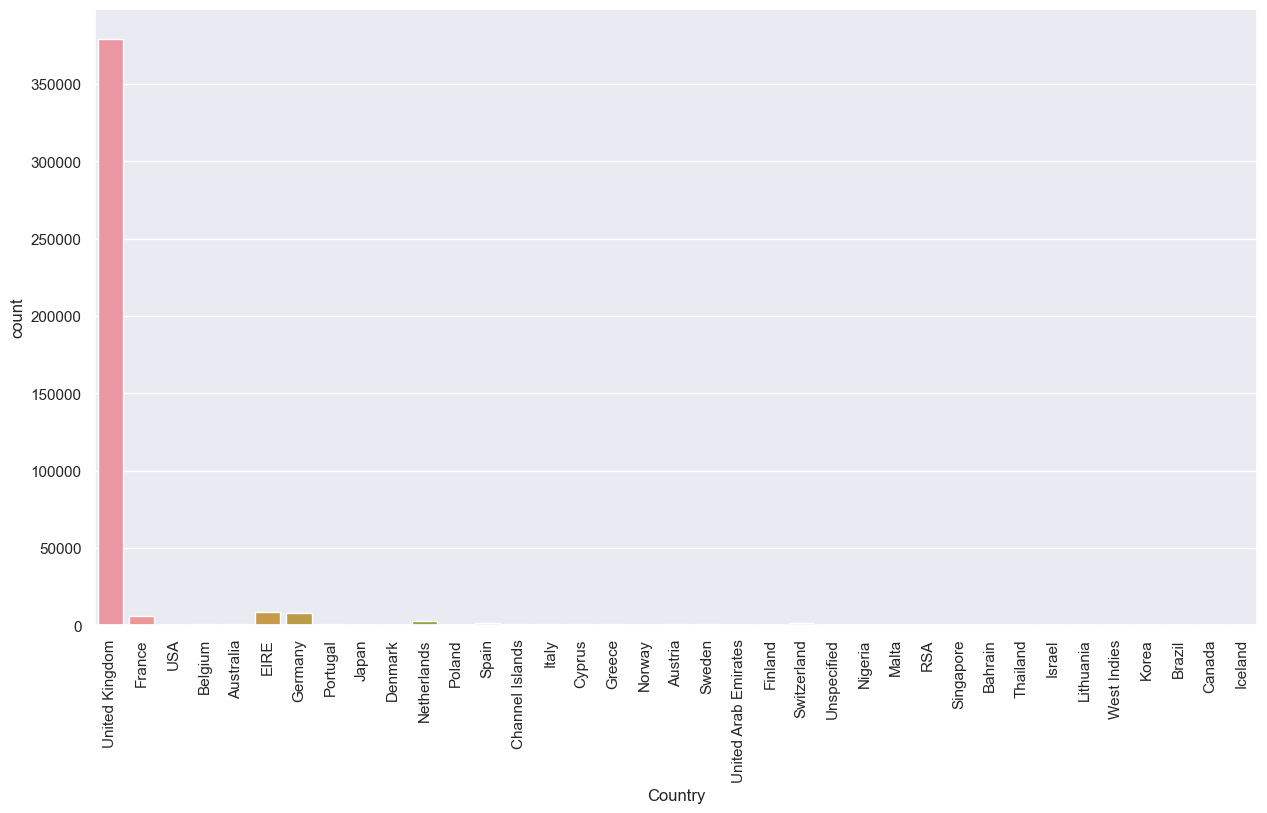

In [294]:
#Data visualization
# Count of transactions by country
sns.set_style('darkgrid')
plt.figure(figsize=(15, 8))
sns.countplot(x='Country', data=data)
plt.xticks(rotation=90)
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_12568\667226288.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['month']= data['InvoiceDate'].dt.month
C:\Users\Admin\AppData\Local\Temp\ipykernel_12568\667226288.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['year']= data['InvoiceDate'].dt.year
C:\Users\Admin\AppData\Local\Temp\ipykernel_12568\667226288.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

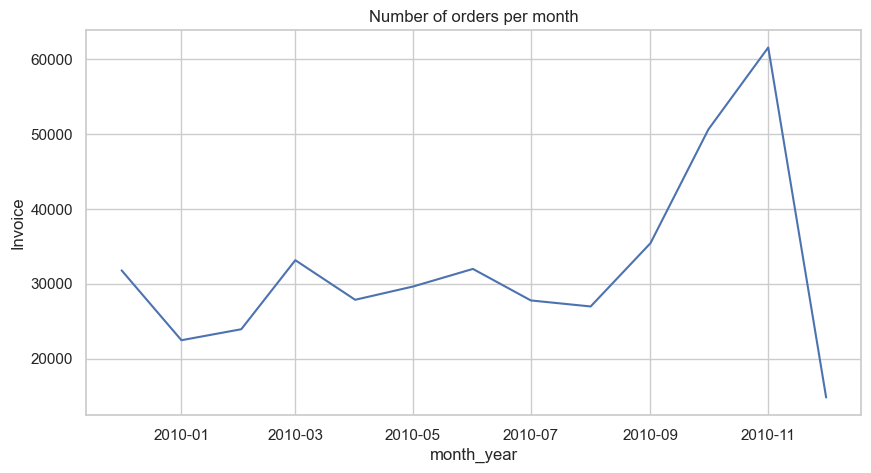

In [295]:
#Calculate order per month
data['month']= data['InvoiceDate'].dt.month
data['year']= data['InvoiceDate'].dt.year
data['month_year'] = pd.to_datetime(data[['year', 'month']].assign(DAY=1))
data['revenue'] = data['Price'] * data['Quantity']
data['month_year'].value_counts().sort_index()

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10,5))
plot = pd.DataFrame(data.groupby(['month_year'])['Invoice'].count()).reset_index()
ax = sns.lineplot(x="month_year", y="Invoice", data = plot)
ax.set_title('Number of orders per month')
plt.show()


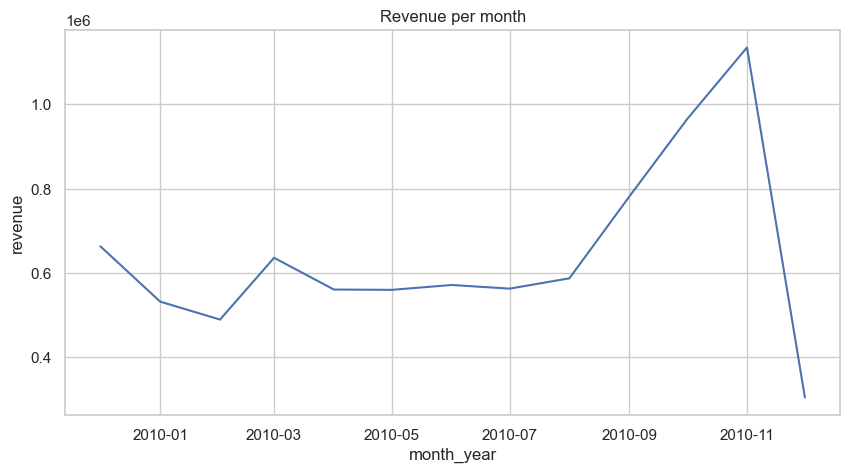

In [296]:
#Calculate revenue per month
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10,5))
plot = pd.DataFrame(data.groupby(['month_year'])['revenue'].sum()).reset_index()
ax = sns.lineplot(x="month_year", y="revenue", data = plot)
ax.set_title('Revenue per month')
plt.show()

We can se that after peaked at 2010, the revenue and also number of order per month decrease gradually

In [297]:
#check duplication for the Customer ID and stocl code column 
groupdt = data.groupby(['Customer ID', 'StockCode']).size().reset_index(name='counts')
groupdt
#discplay the groupdt data frame 
groupdt[groupdt['counts'] > 1]

,Customer ID,StockCode,counts
26,12346.0,M,10
27,12346.0,TEST001,9
90,12347.0,84558A,2
125,12349.0,21231,3
126,12349.0,21232,3
...,...,...,...
275519,18287.0,22465,2
275531,18287.0,22866,2
275535,18287.0,84270,2
275541,18287.0,72349B,2


In [298]:
analysisdata = data[['Invoice',"TotalPrice","InvoiceDate"]].groupby([data.InvoiceDate.dt.year,data.InvoiceDate.dt.month,"Invoice"]).sum()
analysisdata

C:\Users\Admin\AppData\Local\Temp\ipykernel_12568\2649129805.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  analysisdata = data[['Invoice',"TotalPrice","InvoiceDate"]].groupby([data.InvoiceDate.dt.year,data.InvoiceDate.dt.month,"Invoice"]).sum()


TotalPrice
InvoiceDate InvoiceDate Invoice            
2009        12          489434       505.30
                        489435       145.80
                        489436       630.33
                        489437       310.75
                        489438      2286.24
...                                     ...
2010        12          C538121      -12.75
                        C538122       -1.25
                        C538123       -7.50
                        C538124      -17.70
                        C538164       -1.95

[23587 rows x 1 columns]

In [299]:
analysisdata2 = data[['Invoice',"TotalPrice","InvoiceDate"]].groupby([data.InvoiceDate.dt.year,data.InvoiceDate.dt.month]).sum()
analysisdata2

C:\Users\Admin\AppData\Local\Temp\ipykernel_12568\3910335897.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  analysisdata2 = data[['Invoice',"TotalPrice","InvoiceDate"]].groupby([data.InvoiceDate.dt.year,data.InvoiceDate.dt.month]).sum()


TotalPrice
InvoiceDate InvoiceDate             
2009        12            663272.050
2010        1             531952.902
            2             489399.586
            3             635996.481
            4             560635.022
            5             559924.550
            6             571459.910
            7             562785.900
            8             587256.460
            9             781033.301
            10            964989.780
            11           1134879.282
            12            304623.350

<AxesSubplot: xlabel='InvoiceDate,InvoiceDate'>

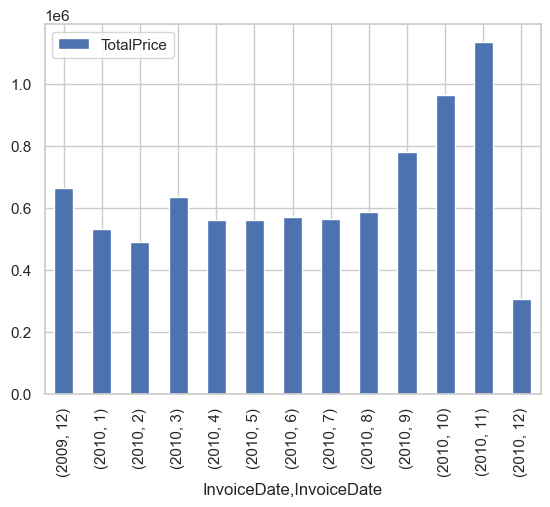

In [300]:
analysisdata2.plot.bar(y='TotalPrice')

array([[<AxesSubplot: title={'center': 'Quantity'}>,
        <AxesSubplot: title={'center': 'InvoiceDate'}>,
        <AxesSubplot: title={'center': 'Price'}>],
       [<AxesSubplot: title={'center': 'Customer ID'}>,
        <AxesSubplot: title={'center': 'TotalPrice'}>,
        <AxesSubplot: title={'center': 'month'}>],
       [<AxesSubplot: title={'center': 'year'}>,
        <AxesSubplot: title={'center': 'month_year'}>,
        <AxesSubplot: title={'center': 'revenue'}>]], dtype=object)

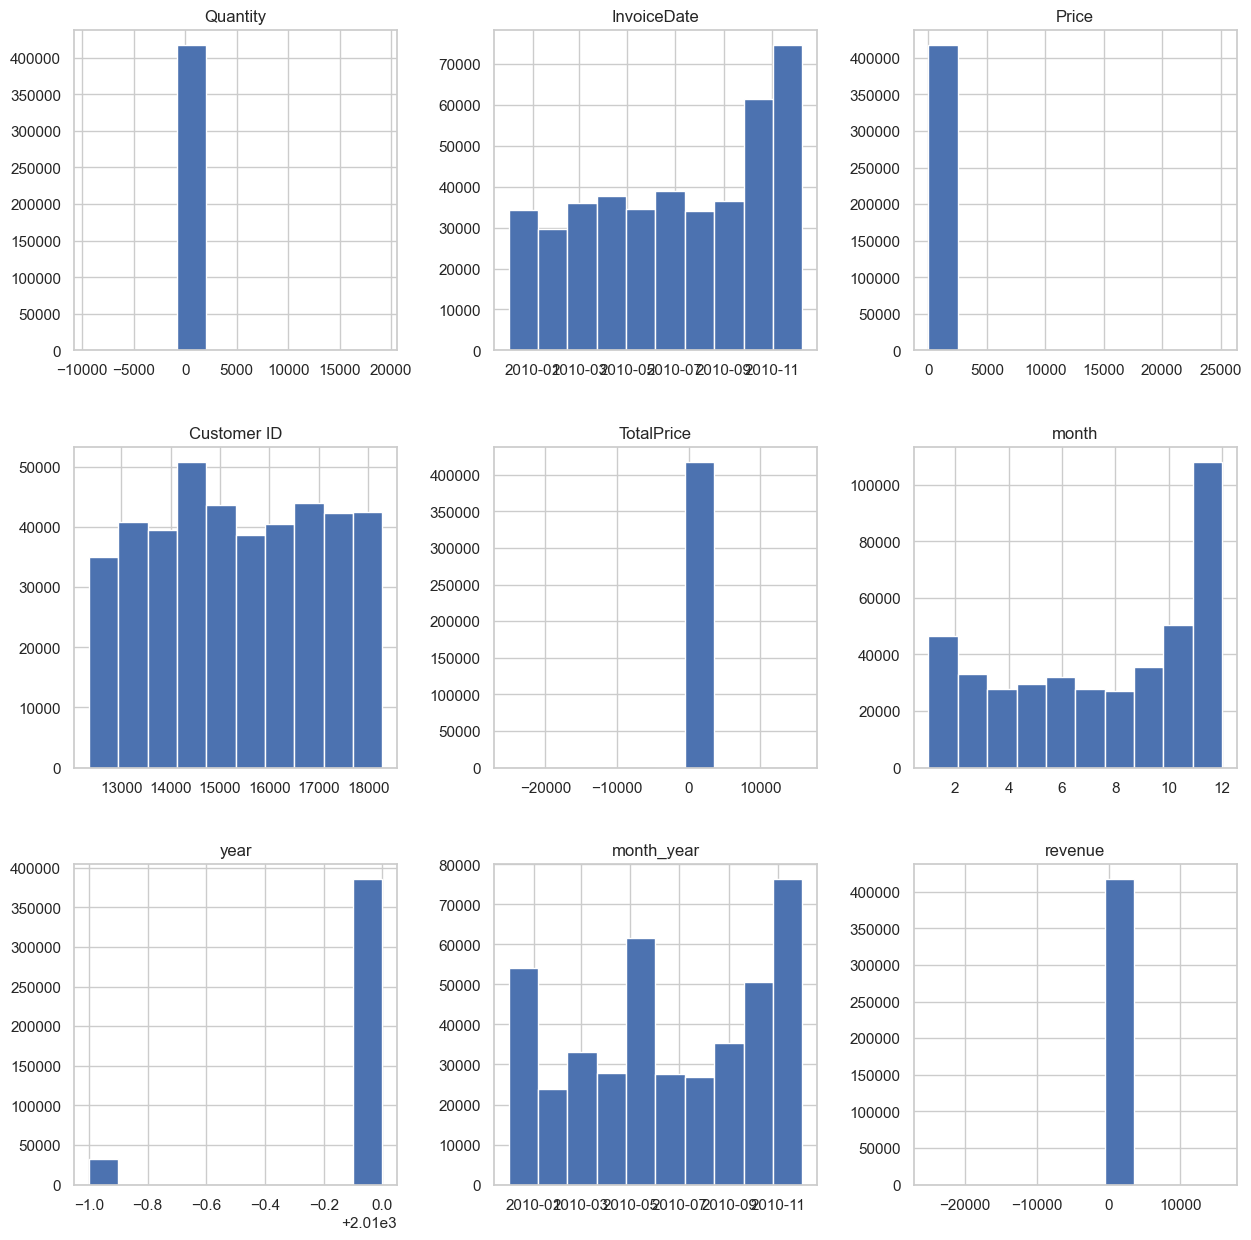

In [301]:
data.hist(figsize = (15,15))


C:\Users\Admin\AppData\Local\Temp\ipykernel_12568\3750976467.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = data.corr()


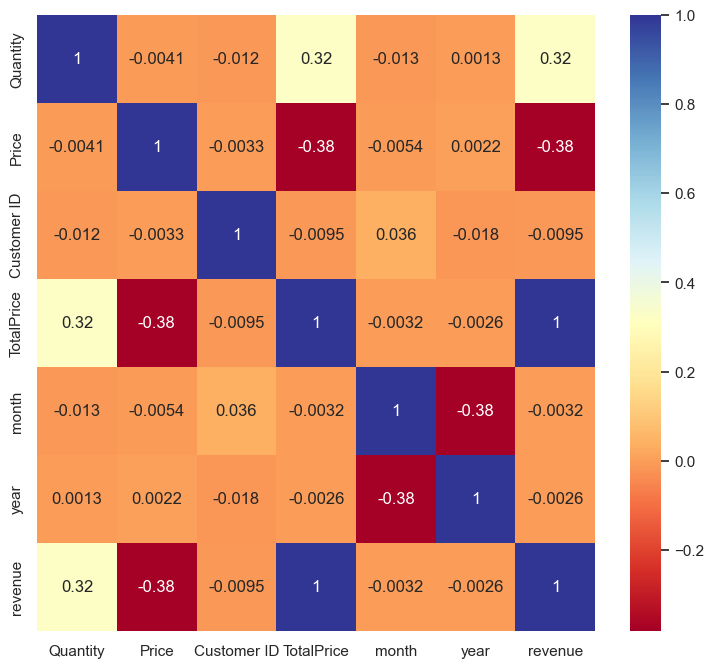

In [302]:
plt.figure(figsize= (9,8))
cor = data.corr() 
sns.heatmap(cor, annot=True, cmap=plt.cm.RdYlBu)
plt.show()

In [303]:
#group customer id and data
CusPri = data.groupby('Customer ID')['TotalPrice'].sum()
CusPri = CusPri.reset_index()
CusPri

,Customer ID,TotalPrice
0,12346.0,-64.68
1,12347.0,1323.32
2,12348.0,222.16
3,12349.0,2646.99
4,12351.0,300.93
...,...,...
4378,18283.0,641.77
4379,18284.0,436.68
4380,18285.0,427.00
4381,18286.0,1188.43


In [304]:
#group by the customer id with the total amount that they spent
#sort the values in descending order
InCus = data.groupby('Customer ID')['Invoice'].count()
InCus = InCus.reset_index()
InCus


,Customer ID,Invoice
0,12346.0,46
1,12347.0,71
2,12348.0,20
3,12349.0,107
4,12351.0,21
...,...,...
4378,18283.0,230
4379,18284.0,29
4380,18285.0,12
4381,18286.0,70


In [305]:
#merge data frames 
customers = pd.merge(CusPri, InCus, on='Customer ID')
customers


,Customer ID,TotalPrice,Invoice
0,12346.0,-64.68,46
1,12347.0,1323.32,71
2,12348.0,222.16,20
3,12349.0,2646.99,107
4,12351.0,300.93,21
...,...,...,...
4378,18283.0,641.77,230
4379,18284.0,436.68,29
4380,18285.0,427.00,12
4381,18286.0,1188.43,70


Also, we can get more details 
In this task, I observes which customer has and has not visited the store.

In [306]:
# find the most recent date the store active
last= data['InvoiceDate'].max()
last


Timestamp('2010-12-09 20:01:00')

In [307]:
data['Last Active']=last - data['InvoiceDate']
data

C:\Users\Admin\AppData\Local\Temp\ipykernel_12568\2508483992.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Last Active']=last - data['InvoiceDate']


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice,month,year,month_year,revenue,Last Active
0,489434,85048,15CMCHRISTMASGLASSBALL20LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.40,12,2009,2009-12-01,83.40,373 days 12:16:00
1,489434,79323P,PINKCHERRYLIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00,12,2009,2009-12-01,81.00,373 days 12:16:00
2,489434,79323W,WHITECHERRYLIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00,12,2009,2009-12-01,81.00,373 days 12:16:00
3,489434,22041,"RECORDFRAME7""SINGLESIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.80,12,2009,2009-12-01,100.80,373 days 12:16:00
4,489434,21232,STRAWBERRYCERAMICTRINKETBOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.00,12,2009,2009-12-01,30.00,373 days 12:16:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFTDOLLROSIE,2,2010-12-09 20:01:00,2.95,17530.0,United Kingdom,5.90,12,2010,2010-12-01,5.90,0 days 00:00:00
525457,538171,22750,FELTCRAFTPRINCESSLOLADOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,3.75,12,2010,2010-12-01,3.75,0 days 00:00:00
525458,538171,22751,FELTCRAFTPRINCESSOLIVIADOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,3.75,12,2010,2010-12-01,3.75,0 days 00:00:00
525459,538171,20970,PINKFLORALFELTCRAFTSHOULDERBAG,2,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,7.50,12,2010,2010-12-01,7.50,0 days 00:00:00


In [308]:
#find the difference between the last date and the date of the invoice
recent = data.groupby('Customer ID')['Last Active'].min()
recent = recent.reset_index()
recent['Last Active']= recent['Last Active'].dt.days
recent

,Customer ID,Last Active
0,12346.0,66
1,12347.0,2
2,12348.0,73
3,12349.0,42
4,12351.0,10
...,...,...
4378,18283.0,17
4379,18284.0,64
4380,18285.0,295
4381,18286.0,111


In [309]:
#group all 
customers = pd.merge(customers, recent, on='Customer ID')
customers

,Customer ID,TotalPrice,Invoice,Last Active
0,12346.0,-64.68,46,66
1,12347.0,1323.32,71,2
2,12348.0,222.16,20,73
3,12349.0,2646.99,107,42
4,12351.0,300.93,21,10
...,...,...,...,...
4378,18283.0,641.77,230,17
4379,18284.0,436.68,29,64
4380,18285.0,427.00,12,295
4381,18286.0,1188.43,70,111


In [310]:
X = customers['TotalPrice'].quantile(0.05)
Y = customers['TotalPrice'].quantile(0.95)
iqr = Y - X

In [311]:
#Use the quartile variable to remove outliers
customers = customers[(customers['TotalPrice'] >= X - 1.5*iqr) & (customers['TotalPrice'] < Y + 1.5*iqr)]


In [312]:
#After removing outliers, we can scale the data 
scc = StandardScaler()
scale= scc.fit_transform(customers[['Invoice','TotalPrice','Last Active']])
scale.shape

(4317, 3)

In [313]:
scaleValue = pd.DataFrame(scale, columns=['Invoice','TotalPrice','Last Active'])
scaleValue

,Invoice,TotalPrice,Last Active
0,-0.310202,-0.738321,-0.258680
1,-0.104760,0.010540,-0.909493
2,-0.523860,-0.583563,-0.187498
3,0.191075,0.724693,-0.502735
4,-0.515643,-0.541065,-0.828141
...,...,...,...
4312,1.201846,-0.357173,-0.756958
4313,-0.449902,-0.467824,-0.279018
4314,-0.589602,-0.473047,2.070007
4315,-0.112978,-0.062237,0.198922


KMean Cluster
We need to provide K value and we can find the K value using elbow graph

In [314]:
target = []
for i in range(2,7):
    kmeans = KMeans(n_clusters=i, max_iter=1000, random_state=42, n_init=50, verbose = True).fit(scaleValue)
    target.append(kmeans.inertia_)  

Initialization complete
Iteration 0, inertia 11574.851592866826.
Iteration 1, inertia 8153.4408046884955.
Iteration 2, inertia 8151.141827240832.
Iteration 3, inertia 8150.745365308309.
Iteration 4, inertia 8150.592262822467.
Iteration 5, inertia 8150.409221624248.
Converged at iteration 5: center shift 7.84395632580445e-05 within tolerance 0.00010000000000000011.
Initialization complete
Iteration 0, inertia 13078.274002259011.
Iteration 1, inertia 9099.09717298839.
Iteration 2, inertia 8857.933307941035.
Iteration 3, inertia 8855.235658960124.
Converged at iteration 3: center shift 8.822965917454962e-05 within tolerance 0.00010000000000000011.
Initialization complete
Iteration 0, inertia 10919.53527989579.
Iteration 1, inertia 8855.978046285521.
Iteration 2, inertia 8855.236978687415.
Converged at iteration 2: center shift 9.255996538801133e-05 within tolerance 0.00010000000000000011.
Initialization complete
Iteration 0, inertia 9894.55022929457.
Iteration 1, inertia 8790.125274088092

In [315]:
print(len(target)) # 5

5


([<matplotlib.axis.XTick at 0x2980fc219c0>,
 [Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6')])

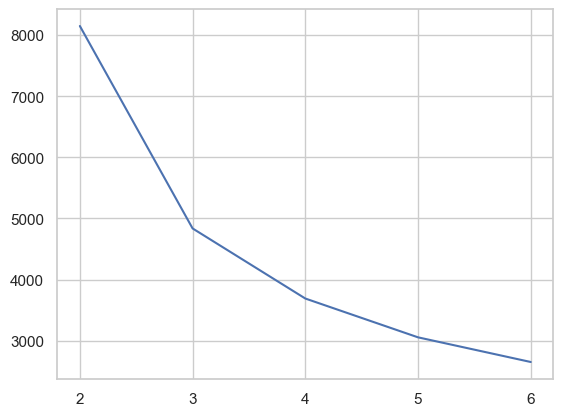

In [316]:
plt.plot(range(2,7,1),target)
plt.xticks(ticks = range(2,7))

In [317]:
# create the final model with 3 clusters 
kmeans = KMeans(n_clusters=3, max_iter=1000, random_state=42, n_init=50, verbose = True).fit(scaleValue)
cluster_labels = kmeans.labels_
customers['Cluster'] = cluster_labels
customers


Initialization complete
Iteration 0, inertia 5316.10423083374.
Iteration 1, inertia 4885.356802703164.
Iteration 2, inertia 4856.0583154279275.
Iteration 3, inertia 4843.965032888282.
Iteration 4, inertia 4838.7337245588615.
Iteration 5, inertia 4837.484298346436.
Iteration 6, inertia 4837.341809412864.
Converged at iteration 6: center shift 8.071467768477226e-05 within tolerance 0.00010000000000000011.
Initialization complete
Iteration 0, inertia 6990.787277103471.
Iteration 1, inertia 5406.15364504101.
Iteration 2, inertia 5105.5159477663265.
Iteration 3, inertia 4968.172304736718.
Iteration 4, inertia 4891.564184308724.
Iteration 5, inertia 4863.707516565328.
Iteration 6, inertia 4850.362309538831.
Iteration 7, inertia 4840.718827625495.
Iteration 8, inertia 4837.830584524565.
Iteration 9, inertia 4837.394888301393.
Iteration 10, inertia 4837.302779879712.
Converged at iteration 10: strict convergence.
Initialization complete
Iteration 0, inertia 6041.986328659963.
Iteration 1, iner

C:\Users\Admin\AppData\Local\Temp\ipykernel_12568\4117562308.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customers['Cluster'] = cluster_labels


,Customer ID,TotalPrice,Invoice,Last Active,Cluster
0,12346.0,-64.68,46,66,1
1,12347.0,1323.32,71,2,1
2,12348.0,222.16,20,73,1
3,12349.0,2646.99,107,42,1
4,12351.0,300.93,21,10,1
...,...,...,...,...,...
4378,18283.0,641.77,230,17,1
4379,18284.0,436.68,29,64,1
4380,18285.0,427.00,12,295,2
4381,18286.0,1188.43,70,111,1


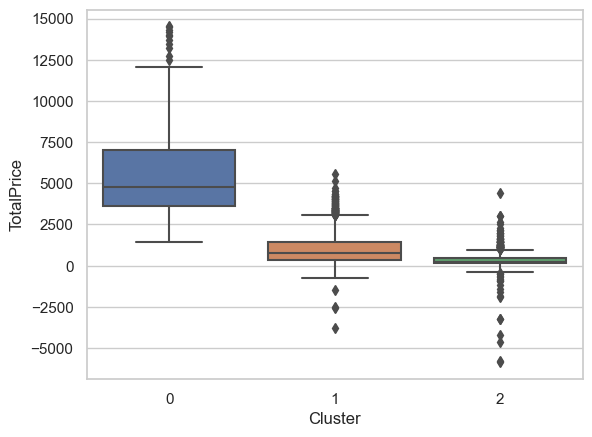

In [318]:
sns.boxplot(x='Cluster', y='TotalPrice', data=customers)
plt.show()

<AxesSubplot: xlabel='Cluster', ylabel='Invoice'>

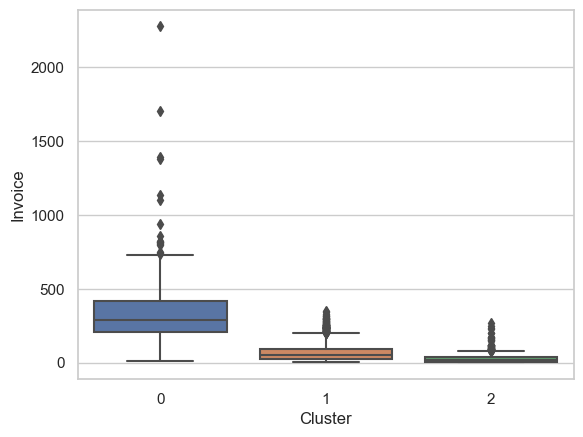

In [319]:
sns.boxplot(x='Cluster', y='Invoice', data=customers)

<AxesSubplot: xlabel='Cluster', ylabel='Last Active'>

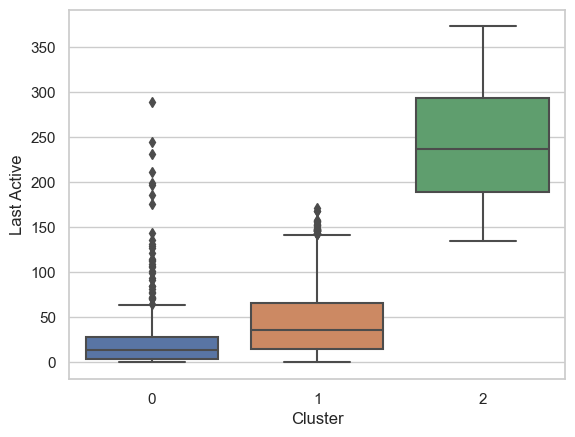

In [320]:
sns.boxplot(x='Cluster', y='Last Active', data=customers)

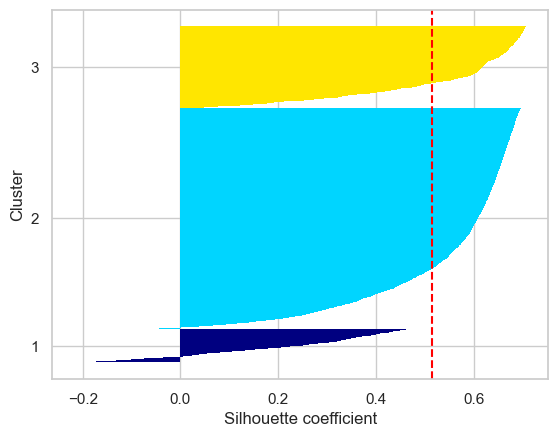

0.515263490702985

In [321]:
#calculate the silhouette score
def plot_silhouette_score(data, labels):
    cluster_labels = np.unique(labels)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(data, labels, metric='euclidean')
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    
    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[labels == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(i / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
        yticks.append((y_ax_lower + y_ax_upper) / 2)
        y_ax_lower += len(c_silhouette_vals)
    
    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color="red", linestyle="--")
    plt.yticks(yticks, cluster_labels + 1)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')
    plt.show()

    return silhouette_avg
    
plot_silhouette_score(scaleValue, cluster_labels)

In [322]:
silhouette = dict()
for k in range(2, 15):
    kmeans = KMeans(init='k-means++', n_clusters=k)
    clusters = kmeans.fit_predict(scaleValue)
    silhouette[k] = silhouette_score(scaleValue, clusters)

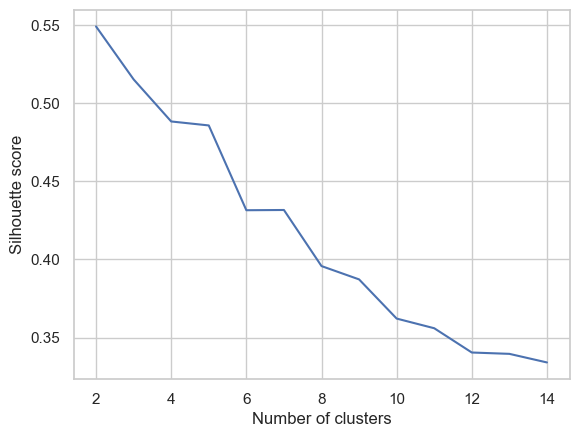

In [323]:
plt.plot (list(silhouette.keys()), list(silhouette.values()))
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()


In [324]:
print('The best number of clusters is: ', max(silhouette, key=silhouette.get))

The best number of clusters is:  2


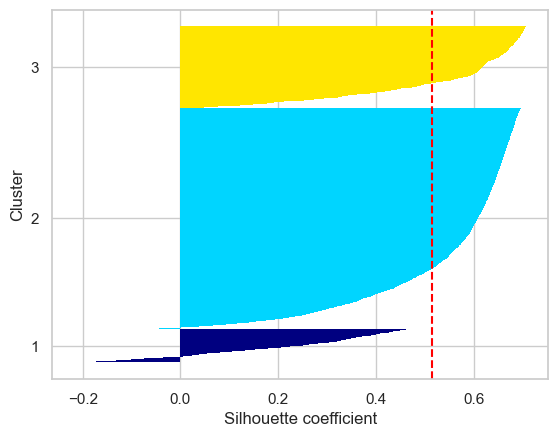

0.515263490702985

In [325]:
plot_silhouette_score(scaleValue, customers['Cluster'])

In [326]:
pd.DataFrame(pd.Series(kmeans.labels_).value_counts(), columns=['Cluster Size'])

,Cluster Size
3,1079
1,730
5,565
8,554
12,354
0,350
10,220
4,171
9,96
11,74


In [327]:
# clustering technique 2: DBSCAN
#generate the model
dbscan = DBSCAN(eps=0.5, min_samples=5, metric='euclidean')
dbscan.fit(scaleValue)

DBSCAN()

In [328]:
#find the number of clusters
labels = dbscan.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_clusters

6

In [329]:
#find the number of noise points
n_noise = list(labels).count(-1)
n_noise

91

In [330]:
#calculate the silhouette score
silhouette= silhouette_score(scaleValue, labels)
silhouette

0.5789194190984394

In [331]:
print("estimate number of clusters: %d" % n_clusters)
print("Silhouette Coefficient: %0.3f" % silhouette_score(scaleValue, labels))

estimate number of clusters: 6
Silhouette Coefficient: 0.579


the silhouette score for kmeans clustering 0.515263490702985
the silhouette score for DBSCAN 0.5789194190984394


## Classification


In [332]:
#Splitting train and test set 
#Support vector classifier
X = customers[['Invoice','TotalPrice','Last Active']]
y = customers['Cluster']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [333]:
def train_and_plot(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    # classification report
    print('\n{}'.format(classification_report(y_test, y_pred)))
    print('Accuracy score: ', accuracy_score(y_test, y_pred))
    print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
    print('Classification report: \n', classification_report(y_test, y_pred))
    plot_confusion_matrix(model, X_test, y_test, cmap='Blues')
    plt.show()

In [334]:
# Naive Bayes
# from sklearn.naive_bayes import GaussianNB (choose model class)
nb_model = GaussianNB() # instantiate model
nb_model.fit(X_train, y_train) #fit the model to the data

GaussianNB()

In [335]:
predictions = nb_model.predict(X_test)
acc = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (acc * 100.0))

Accuracy: 95.60%


In [336]:
pipeline = Pipeline([('scaler', StandardScaler()), ('estimator', SVC())])
param = {'estimator__C': [0.1, 1, 10, 100, 1000], 'estimator__gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'estimator__kernel': ['rbf']}
grid = GridSearchCV(pipeline, param_grid=param, cv=5, verbose=2)
grid.fit(X_train, y_train)
print(grid.best_params_)
print(grid.best_score_)
print(grid.best_estimator_)
print(grid.score(X_test, y_test))


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END estimator__C=0.1, estimator__gamma=1, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=0.1, estimator__gamma=1, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=0.1, estimator__gamma=1, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=0.1, estimator__gamma=1, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=0.1, estimator__gamma=1, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=0.1, estimator__gamma=0.1, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=0.1, estimator__gamma=0.1, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=0.1, estimator__gamma=0.1, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=0.1, estimator__gamma=0.1, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=0.1, estimator__gamma=0.1, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=0.1, estimator__

## Linear regression 

In [337]:
#fold cross validation 
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = grid, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END estimator__C=0.1, estimator__gamma=1, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=0.1, estimator__gamma=1, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=0.1, estimator__gamma=1, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=0.1, estimator__gamma=1, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=0.1, estimator__gamma=1, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=0.1, estimator__gamma=0.1, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=0.1, estimator__gamma=0.1, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=0.1, estimator__gamma=0.1, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=0.1, estimator__gamma=0.1, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=0.1, estimator__gamma=0.1, estimator__kernel=rbf; total time=   0.0s
[CV] END estimator__C=0.1, estimator__

In [ ]:
# create test and train
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size = 0.3)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_train.shape)

In [ ]:
lrm = linear_model.LinearRegression()
lrm_model = lrm.fit(X_train, y_train)
lrm_prediction = lrm.predict(X_test)

In [ ]:
lrm_prediction[0:10]

In [ ]:
print(lrm_prediction)
type(lrm_prediction)

In [ ]:
df2 = pd.DataFrame(X_test)
df2["revenue actual"] = y_test
df2["revenue pre"] = lrm_prediction
df2.head(10)

In [ ]:
plt.scatter (y_test, lrm_prediction) 
plt.title ("Plot of Predicted vs. Actual Values") 
plt.xlabel ('revenue actual')
plt.ylabel ('revenue pre')
print('Accuracy: ', lrm_model.score(X_test, y_test) * 100)

## Multiple linear regression

In [ ]:
X = data.drop(["revenue", "Description", "InvoiceDate", "Country", "month_year", "StockCode", "Invoice"], axis = 1).values
y = data["revenue"].values

In [ ]:
# split to test and train set
X_train,X_test,y_train,y_test=train_test_split(X,y, test_size = 0.3, random_state = 0)
ml = LinearRegression()
ml.fit(X_train, y_train)

In [ ]:
y_pred = ml.predict(X_test)
plt.figure(figsize = (10,5))
plt.scatter(y_test, y_pred)
plt.xlabel("actual")
plt.ylabel("predict")
print("Accuracy: ", r2_score(y_pred, y_test) * 100)

In [ ]:
pred_y_df = pd.DataFrame({'Actual revenue': y_test, 'Predicted revenue': y_pred, 'Difference': y_test-y_pred})
pred_y_df [0:20]